### Summary

작성일 : 19/08/12

<가설>     
사기 거래를 일으키는 악성 유저들은 짧은 시간 내에 ***다양한 카드***로 사기를 일으키지 않을까?  
  
<전제>  
card1 - 카드 상품(ex. 삼성 더오 신용카드, 신한 00 카드 등),  D8 - 가입일 이라고 가정  
  
<방법>   
1) 가입일(account_make_date)/디바이스 정보(DeviceInfo)/같은 거래금액(TransactionAmt)을 바탕으로 'Potential client_id'(동일 고객으로 추정되는 값) 변수 생성    
2) 30분 간격으로 Potential client_id의 거래 횟수, unique 카드 갯수, Fraud ratio 계산  
3) Fraud == 0/1 여부에 따른 count_per_unique(카드 갯수 / 거래횟수)의 분포 비교  
  
<결론>  
1) 30분 내에 같은 금액을 결제하는 동일 고객(추정)의 90% 이상은 모두 사기거나(Fraud ==1), 모두 정상 거래(Fraud==0)  
2) Fraud 여부에 따라 count_per_uniuqe 분포가 다른 것을 확인(하단 그래프 참조), 즉 사기를 치는 사람들은 짧은 시간 내에 다양한 카드로 거래를 진행
  
<향후 계획>  
1) 위의 결론 Feature 반영 예정  
2) 사기꾼들이 좋아하는 카드 조합/거래 패턴 등 파악 예정

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc, datetime, time
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
from plotnine import *
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_trans = pd.read_csv("/Users/jeong/downloads/IEEE/input/train_transaction.csv")
train_idf = pd.read_csv("/Users/jeong/downloads/IEEE/input/train_identity.csv")

test_trans = pd.read_csv("/Users/jeong/downloads/IEEE/input/test_transaction.csv")
test_idf = pd.read_csv("/Users/jeong/downloads/IEEE/input/test_identity.csv")

train_trans = pd.merge(train_trans, train_idf, on = 'TransactionID', how = 'left')
test_trans = pd.merge(test_trans, test_idf, on = 'TransactionID', how = 'left')

In [5]:
# account_make_day 만들기
# 현우님 커널 코드 참조

start_date = datetime.datetime.strptime('2017.11.30', '%Y.%m.%d')
train_trans['timeblock'] = train_trans['TransactionDT'].apply(lambda x: datetime.timedelta(seconds = x) + start_date ) 
test_trans['timeblock'] = test_trans['TransactionDT'].apply(lambda x: datetime.timedelta(seconds = x) + start_date ) 

tb = train_trans['timeblock']
train_trans.drop('timeblock', 1, inplace=True)
train_trans.insert(0, 'timeblock', tb)

tb = test_trans['timeblock']
test_trans.drop('timeblock', 1, inplace=True)
test_trans.insert(0, 'timeblock', tb)

def account_start_date(val):
    if np.isnan(val) :
        return np.NaN
    else:
        days=  int( str(val).split('.')[0])
        return pd.Timedelta( str(days) +' days')

train_trans['account_start_day'] = train_trans['D8'].apply(account_start_date)
test_trans['account_start_day'] = test_trans['D8'].apply(account_start_date)

train_trans['account_make_date'] = (train_trans['timeblock'] - train_trans['account_start_day']).dt.date
test_trans['account_make_date'] = (test_trans['timeblock'] - test_trans['account_start_day']).dt.date

#### 1) Potential client_id column 생성
 - account_make_date, DeviceInfo, TransactionAmt를 바탕으로 potential clinet_id 컬럼을 생성
 - 특히 account_make_date는 유저 식별에 중요한 변수라고 판단하여 NA값을 제외한 데이터만 subset

In [6]:
train_trans['poten_client_id'] = train_trans['TransactionAmt'].astype('str') + train_trans['account_make_date'].astype('str') + train_trans['DeviceInfo']
ex = train_trans[train_trans['account_make_date'].notnull()]

#### 2) 30분 간격으로 거래 횟수, fraud ratio 계산

In [7]:
ex['half_hour_cut'] = round(ex['TransactionDT'] / 60,0) // 30
ex2 = ex.groupby(['poten_client_id','half_hour_cut']).agg({"isFraud" : ['count','mean'], "card1" :['nunique']}).reset_index()
ex2.columns = ['poten_client_id','half_hour_cut', 'fraud_count','fraud_mean','card1_nuniq']
ex2 = ex2[ex2['fraud_count'] != 1]
ex2 = ex2.sort_values(by = 'fraud_count', ascending = False)

In [8]:
ex2.head(10)

,poten_client_id,half_hour_cut,fraud_count,fraud_mean,card1_nuniq
8877,106.02018-04-24Windows,8257.0,83,0.0,1
49267,75.02018-04-24Windows,8256.0,75,0.0,1
8876,106.02018-04-24Windows,8239.0,58,0.0,1
10761,125.02018-04-24Windows,8254.0,57,0.0,1
10759,125.02018-04-24Windows,8252.0,47,0.0,1
9314,110.02018-04-24Windows,8236.0,43,0.0,1
8830,105.02018-04-24Windows,8237.0,31,0.0,1
9316,110.02018-04-24Windows,8240.0,29,0.0,1
49266,75.02018-04-24Windows,8255.0,29,0.0,1
8856,106.02018-04-24Windows,7899.0,26,0.0,1


In [9]:
ex2[ex2['fraud_count']>5].fraud_mean.value_counts()

0.000000    190
1.000000     99
0.428571      1
0.285714      1
0.750000      1
Name: fraud_mean, dtype: int64

신기하게 대부분 값이 0아니면 1, 즉 모두 사기거나, 모두 정상거래를 나타냈다.  
가입일 + 같은거래금액 + 같은 디바이스 정보가 어느정도 client_id를 나타내는 지표이지않을까?

#### 3) 분포 비교
- count_per_unique(전체 거래 횟수 대비 카드 종류의 갯수)의 차이가 보이는지 확인
- fraud_count > 5인 데이터만 subset

In [10]:
ex2['count_per_unique'] = ex2['card1_nuniq'] / ex2['fraud_count']

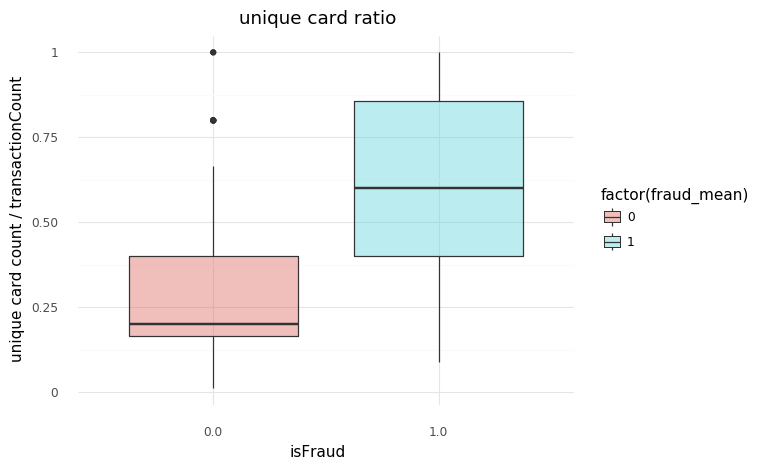

<ggplot: (-9223372029301529684)>

In [11]:
ggplot(ex2[(ex2['fraud_count']>=5) & ((ex2['fraud_mean']==0) | (ex2['fraud_mean']==1))], aes( x = 'factor(fraud_mean)',y ='count_per_unique', fill = 'factor(fraud_mean)')) + geom_boxplot(alpha = 0.4) + xlab("isFraud") + ylab("unique card count / transactionCount") + ggtitle("unique card ratio") + theme_minimal()

- 정상 거래자의 경우 대부분 한개의 카드로 결제를 한 반면, 사기 거래의 경우 여러 종류의 카드로 결제한 것을 알 수 있다.  
- 다만 이 결과의 한계점은, device, account_make_day 등이 존재하지 않는 경우 적용할 수 없다는 점이다.
  (따라서 NA값이 많은 이 데이터에서는 이 결과의 효과가 적을수밖에..)
- 그래서 현재 드는 생각은 지금 발견되는 사기 거래자/정상 거래자들의 데이터에서 card, 시간 등의 특성들을 좀더 깊게 파악하고,(예를들어 사기 거래자들은 이러이러한 card1 콤비네이션을 쓰더라..) 이를 바탕으로 전체 데이터에도 적용할 수 있는 feature들을 발굴해보는?? 방향으로 진행해 보고자 한다.
- And 같은 user를 뽑아낼 수 있는 다양한 변수들을 발굴할 필요도 있음